<h1 ><big><center> TP Introduction to Probabilistic Graphical Models</center></big></h1>

In [2]:
# importations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadr

## Gaussian Mixture models and EM

#### Auxiliary functions for sampling GMM model

In [3]:
def discrete_sampling(p,X):
    '''inputs:
    p: array of probabilities p_i
    X: array of values taken by the random variable X 
    output:
    sampled value of X'''
    u=np.random.uniform()
    return X[np.nonzero(1*np.cumsum(p)>u)[0][0]] 

In [4]:
def generate_samples(p,means,covariance, n):
    '''generates n samples from a GMM with parameters p means and covariance
    outputs: an array of size n with elements generated by the GMM
    '''
    samples=[]
    X=np.arange(len(p)).astype(int)
    for k in range(n):
        
        i=discrete_sampling(p,X)
        
        S=np.random.multivariate_normal(means[i],covariance[i])
        samples.append(S)
    return np.array(samples)

#### Function to calculate multivariate Gaussian pdf 

In [5]:
def multivariate_gaussian(x,mean,cov):
    ''' function calculating multivariate gaussian pdf
    inputs:
    x: points on which we evaluate the density
    mean: average of the gaussian
    cov: covariance matrix of the gaussian
    output:
    d: list of densities p(x|mu,sigma)'''
    N=x[0].shape[0]
    cov_inv=np.linalg.inv(cov)
    #x_minus_mu=(x-mu).reshape(N,1)
    factor=1/(np.sqrt(((2*np.pi)**N)*np.abs(np.linalg.det(cov))))
    d=factor*np.array([np.exp(-0.5*((e-mean).T@cov_inv@(e-mean))) for e in x])
    
    return d

In [17]:
def EM_algorithm_PGM(K, x, maxiter=1000, stop_criterion=1e-5, kmeans=False):
    '''EM algorithm
    inputs:
    K: number of clusters
    x: data points
    outputs:
    sigma: array of p final covariance matrixes
    mu: array of p final expectations matrixes
    p: array of p final class probabilities
    '''
    #usefull dimensions
    n,d=x.shape
    m=K #number of classes
    
    #initalisation:
    
    p_0=np.random.rand(m)
    p=p_0/(np.sum(p_0))
    
    #initializing all the means  to means of random points of the data
    mu=np.random.rand(m,d)
    

    sigma=np.zeros((m,d,d))
    for i in range(m):
        U=np.random.rand(d,d)
        sigma[i]=U@U.T  
        
    # BEGIN OF THE EM    
    to=np.zeros((m,n))
    criterion=np.inf
    itere=0
    Likelihoods=[]
    #making the stop criterion relative to the number of classes
    stop_criterion=stop_criterion*np.sqrt(m)
    while(1):
        
        #keeping track of variables for stopping criterion
        past_p=np.copy(p)
        past_mu=np.copy(mu)
        past_sigma=np.copy(sigma)
        
        #looking if we have to stop:
        if ((criterion<stop_criterion) or itere==maxiter):
            break
            
        #E-STEP
        
        #computing to_k_i:
        for i in range(m):
            
            to[i]=multivariate_gaussian(x, mean=mu[i], cov=sigma[i])*p[i] #compute p_theta(x|m)*p(m) for all x 
                                                                   #at fixed class m
                
        #normalizing, we also take benefit of this loop to obtain the likelihood 
        #(sum of the log of the obtained denominators)
        likeli=0
        for j in range(n):
            
            sume=np.sum(to[:,j])
            to[:,j]=to[:,j]/sume #normalizing #adding eventually 1e-5 to avoid det=0
            likeli+=np.log(sume)
        Likelihoods.append(likeli)
            
        
        #M-STEP
        for k in range(m):
            
            p[k]=np.sum(to[k,:])/n
            nk=p[k]*n
            mu[k]=to[k,:].T@x/nk
            
            aux= x-np.repeat(mu[k].reshape(1,d),n,0)
            sigma[k]=np.dot((aux.T * to[k,:]), aux)/nk +1e-6*np.eye(d) #adding extra term to avoid singular matrixes
            
            
        
        #updating stopping criterion and itere
        criterion=np.linalg.norm(past_p-p)/np.linalg.norm(past_p)
        criterion+=np.linalg.norm(past_mu-mu)/np.linalg.norm(past_mu)
        criterion+=np.linalg.norm(past_sigma-sigma)/np.linalg.norm(past_sigma)
        itere+=1
        
      
    MAP_Membership=np.argmax(to,axis=0)
    print('number of iterations:')
    print(itere)
    print('last criterion value:')
    print(criterion)
    return p,mu, sigma, Likelihoods, MAP_Membership
        

#### First a simple 2D example with 4 classes

Text(0, 0.5, 'x2')

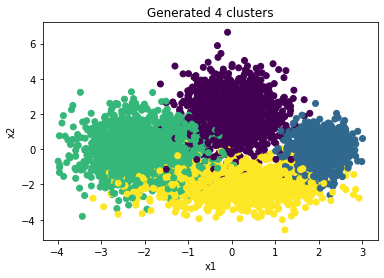

In [18]:
p=np.array([0.25,0.25,0.25,0.25])
means=np.array([[0,2],[2,0],[-2,0],[0,-2]])


covariances=np.zeros((4,2,2))
for i in range(4):
    U=np.random.rand(2,2)
    covariances[i]=U@U.T
    

def generate_samples_with_classes(p,means,covariance, n):
    '''generates n samples from parameters p means and covariance
    outputs: an array of size n with elements [x,y,c] where c is the class of the point
    '''
    samples=[]
    X=np.arange(len(p))
    for k in range(n):
        
        i=discrete_sampling(p,X)
        x,y=np.random.multivariate_normal(means[i],covariance[i])[0], np.random.multivariate_normal(means[i],covariance[i])[1]
        samples.append(np.array([x,y,i]))
    return np.array(samples)
    
n=5000
G=generate_samples_with_classes(p,means,covariances, n)
plt.scatter(G[:,0], G[:,1], c=G[:,2])
plt.title('Generated 4 clusters')

plt.xlabel('x1')
plt.ylabel('x2')


Values to be found:
p:
[0.25 0.25 0.25 0.25]
means
[[ 0  2]
 [ 2  0]
 [-2  0]
 [ 0 -2]]
sigmas:
[[[0.32272723 0.63821529]
  [0.63821529 1.26360446]]

 [[0.09777596 0.21806092]
  [0.21806092 0.48644172]]

 [[0.51697562 0.56244547]
  [0.56244547 1.23259844]]

 [[1.04417745 0.7136125 ]
  [0.7136125  0.52040476]]]
values found:
number of iterations:
298
last criterion value:
1.859791555219667e-06
p:
[0.26468968 0.24734967 0.23183993 0.25612072]
means
[[-2.00751975 -0.0892921 ]
 [ 0.00827682  1.97556074]
 [ 0.051438   -2.00325519]
 [ 1.9974879  -0.01168395]]
sigmas:
[[[ 0.53115885 -0.02101979]
  [-0.02101979  1.3241126 ]]

 [[ 0.31121716  0.00441519]
  [ 0.00441519  1.33155176]]

 [[ 0.97324112 -0.01460579]
  [-0.01460579  0.49604244]]

 [[ 0.10380146  0.00536222]
  [ 0.00536222  0.45927374]]]


Text(0.5, 1.0, 'our data with the GMM we learnt')

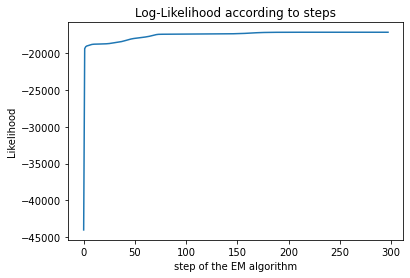

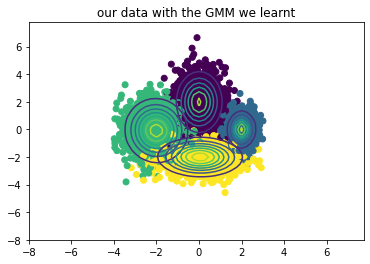

In [19]:
print('Values to be found:')
print('p:')
print(p)
print('means')
print(means)
print('sigmas:')
print(covariances)

print('values found:')
      
#number of class
K=4

points=np.copy(G[:,[0,1]])
      
p_EM,mu_EM, sigma_EM, likelihoods, MAP_Membership=EM_algorithm_PGM(K, points, maxiter=1000, stop_criterion=1e-6)

print('p:')
print(p_EM)
print('means')
print(mu_EM)
print('sigmas:')
print(sigma_EM)

plt.figure()
plt.plot(likelihoods)   
plt.title('Log-Likelihood according to steps')
plt.xlabel('step of the EM algorithm')
plt.ylabel('Likelihood')


plt.figure()
plt.scatter(G[:,0], G[:,1], c=G[:,2])

delta = 0.25
x = np.arange(-8.0, 8.0, delta)
y = np.arange(-8.0, 8.0, delta)
X, Y = np.meshgrid(x, y)

for i in range(K):
    Z =np.array([np.array([x,y]) for (x,y) in zip(X.ravel(), Y.ravel())])#.reshape(X.shape)
    Z=multivariate_gaussian(Z, mean=mu_EM[i], cov=sigma_EM[i]).reshape(X.shape)
    Z[Z==0]=1e-7
    plt.contour(X,Y,Z)
    
plt.title('our data with the GMM we learnt')






Text(0.5, 1.0, 'Predicted Classes of Points from our model')

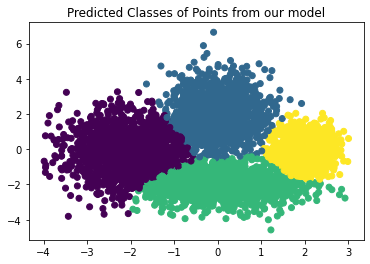

In [24]:
#### Datas with our predicted classes from the MAP membership
plt.figure()
plt.scatter(G[:,0], G[:,1], c=MAP_Membership)
plt.title('Predicted Classes of Points from our model')

#### Testing on our data

In [25]:
### Obtaining the data
data = pyreadr.read_r("data/decathlon.RData")
array = np.array(list(data.items()))
data=array[0][1].to_numpy()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


number of iterations:
1000
last criterion value:
nan
p:
[nan nan nan]
means
[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
sigmas:
[[[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan n

IndexError: index 4095 is out of bounds for axis 0 with size 3

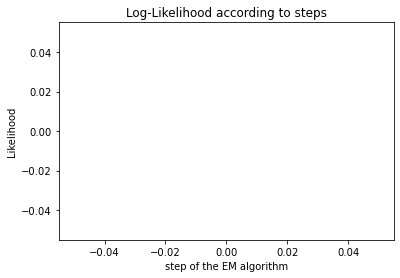

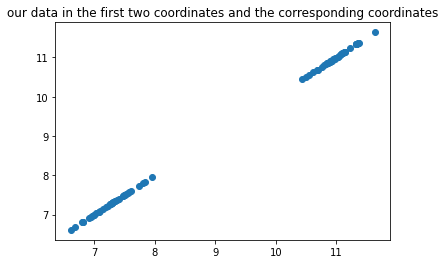

In [26]:
K=3
      
points=np.copy(data)
      
p_EM,mu_EM, sigma_EM, likelihoods, MAP_Membership=EM_algorithm_PGM(K,points, maxiter=1000, stop_criterion=1e-6)

print('p:')
print(p_EM)
print('means')
print(mu_EM)
print('sigmas:')
print(sigma_EM)

plt.figure()
plt.plot(likelihoods)   
plt.title('Log-Likelihood according to steps')
plt.xlabel('step of the EM algorithm')
plt.ylabel('Likelihood')


### Plotting datas according to the first 2 coordinates and the associated GMM
plt.figure()
plt.scatter(data[:,0:2], data[:,0:2])
plt.title('our data in the first two coordinates and the corresponding coordinates')

delta = 0.25
x = np.arange(-8.0, 8.0, delta)
y = np.arange(-8.0, 8.0, delta)
X, Y = np.meshgrid(x, y)

for i in range(4):
    Z =np.array([np.array([x,y]) for (x,y) in zip(X.ravel(), Y.ravel())])#.reshape(X.shape)
    n=Z.shape[0]
    Z_2=np.zeros((n,10))
    for i,z in enumerate(Z):
        Z_2[i,0:2]=z
    Z=multivariate_gaussian(Z_2, mean=mu_EM[i], cov=sigma_EM[i]).reshape(X.shape)
    plt.contour(X,Y,Z)
    